In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools
import torch
import torch.nn as nn
import torch.utils.data as data
import torchSNS as tSNS
from torchSNS.torch import SNSCell,SNSCell_modulation
from scipy.io import loadmat

The torchSNS package only provides a RNNcell, so here we define a nn.Module that packs the cell into a RNN for entire sequence processing

In [32]:
# nn.Module that unfolds a RNN cell into a sequence 
class RNNSequence(nn.Module):
    def __init__(
        self,
        rnn_cell,
    ):
        super(RNNSequence, self).__init__()
        self.rnn_cell = rnn_cell

    def forward(self, x):
        device = x.device
        batch_size = x.size(0)
        seq_len = x.size(1)
        hidden_state = torch.zeros(
            (batch_size, self.rnn_cell.state_size), device=device
        )
        outputs = []
        for t in range(seq_len):
            inputs = x[:, t]
            new_output, hidden_state = self.rnn_cell.forward(inputs, hidden_state)
            outputs.append(new_output)
        outputs = torch.stack(outputs, dim=1)  # return entire sequence
        return outputs

In [47]:
# nn.Module that unfolds a RNN cell into a sequence 
class RNNSequence_modulation(nn.Module):
    def __init__(
        self,
        rnn_cell,
    ):
        super(RNNSequence_modulation, self).__init__()
        self.rnn_cell = rnn_cell

    def forward(self, x):
        device = x.device
        batch_size = x.size(0)
        seq_len = x.size(1)
        hidden_state = torch.zeros(
            (batch_size, self.rnn_cell.state_size), device=device
        )
        a = torch.zeros((batch_size, self.rnn_cell.state_size))
        buffer = torch.zeros((batch_size, self.rnn_cell.buffer_size, self.rnn_cell.state_size))
        outputs = [torch.zeros((batch_size, self.rnn_cell.state_size))]
        for t in range(seq_len - 1):
            inputs = x[:, t]
            new_output, hidden_state, a, buffer = self.rnn_cell.forward(inputs, hidden_state, a, buffer)
            outputs.append(new_output)
        outputs = torch.stack(outputs, dim=1)  # return entire sequence
        return outputs

For the training we will use Pytorch-Lightning, thus we have to define our learner module. 
**Important:** As some of the parameters of the SNS are constraints (e.g., to non-negative values, we have to perform a postprocessing step after each optimizer update to project the parameters back to the admissible range.
The ```pytorch.SNSCell module``` provides a simple method called ```apply_weight_constraints()``` that takes care of that and needs to be called after each optimizer step.

Next we define some toy dataset and create the corresponding DataLoaders

In [ ]:
in_features = 1
out_features = 1
N = 2401  # Length of the time-series
# Input feature is a 1-D constant
data_x = np.ones([1,N,1])
data_x[0,:240 * 3,0] = 0
data_x = torch.Tensor(data_x)

In [34]:
def layer_initialization(layer, theta_min_in, theta_max_in, theta_min_out, theta_max_out, tau, b, sensory_erev, sensory_w, R):
    # Parameter initialization
    in_features = layer._wiring.input_dim
    out_features = layer._wiring.output_dim
    neuron_num = layer._wiring.units
    with torch.no_grad():
        layer._params["tau"].requires_grad = False
        layer._params["b"].requires_grad = False
        layer._params["input_w"].requires_grad = False
        layer._params["input_b"].requires_grad = False
        layer._params["output_w"].requires_grad = False
        layer._params["output_b"].requires_grad = False
        layer._params["sensory_mu"].requires_grad = False
        layer._params["sensory_sigma"].requires_grad = False
        layer._params["mu"].requires_grad = False
        layer._params["sigma"].requires_grad = False
        layer._params["sensory_erev"].requires_grad = False
        layer._params["sensory_w"].requires_grad = False
        layer._params["erev"].requires_grad = False
        layer._params["w"].requires_grad = False

        layer._params["tau"].data = tau
        layer._params["b"].data = b
        layer._params["input_w"].data = torch.Tensor(
            R / (theta_max_in - theta_min_in))
        layer._params["input_b"].data = torch.Tensor(
            R * theta_min_in / (theta_min_in - theta_max_in))
        layer._params["output_w"].data = torch.Tensor(
            (theta_max_out - theta_min_out) / R)
        layer._params["output_b"].data = torch.Tensor(theta_min_out)
        layer._params["sensory_mu"].data = R/2 * \
            torch.ones((in_features, neuron_num))
        layer._params["sensory_sigma"].data = R / \
            2 * torch.ones((in_features, neuron_num))
        layer._params["mu"].data = R/2 * torch.ones((neuron_num, neuron_num))
        layer._params["sigma"].data = R/2 * \
            torch.ones((neuron_num, neuron_num))
        layer._params["sensory_erev"].data = sensory_erev
        layer._params["sensory_w"].data = sensory_w
        layer._params["erev"].data = torch.zeros((neuron_num, neuron_num))
        layer._params["w"].data = torch.zeros((neuron_num, neuron_num))

In [46]:
def modulation_layer_initialization(layer, theta_min_in, theta_max_in, theta_min_out, theta_max_out, tau, b, tau_io, t_d, beta, k_io, sensory_erev, sensory_w, R):
    # Parameter initialization
    in_features = layer._wiring.input_dim
    out_features = layer._wiring.output_dim
    neuron_num = layer._wiring.units
    with torch.no_grad():
        layer._params["tau"].requires_grad = False
        layer._params["b"].requires_grad = False
        layer._params["tau_io"].requires_grad = False
        layer._params["t_d"].requires_grad = False
        layer._params["beta"].requires_grad = False
        layer._params["k_io"].requires_grad = False
        layer._params["input_w"].requires_grad = False
        layer._params["input_b"].requires_grad = False
        layer._params["output_w"].requires_grad = False
        layer._params["output_b"].requires_grad = False
        layer._params["sensory_mu"].requires_grad = False
        layer._params["sensory_sigma"].requires_grad = False
        layer._params["mu"].requires_grad = False
        layer._params["sigma"].requires_grad = False
        layer._params["sensory_erev"].requires_grad = False
        layer._params["sensory_w"].requires_grad = False
        layer._params["erev"].requires_grad = False
        layer._params["w"].requires_grad = False

        layer._params["tau"].data = tau
        layer._params["b"].data = b
        layer._params["tau_io"].data = tau_io
        layer._params["t_d"].data = t_d
        layer._params["beta"].data = beta
        layer._params["k_io"].data = k_io
        layer._params["input_w"].data = torch.Tensor(
            R / (theta_max_in - theta_min_in))
        layer._params["input_b"].data = torch.Tensor(
            R * theta_min_in / (theta_min_in - theta_max_in))
        layer._params["output_w"].data = torch.Tensor(
            (theta_max_out - theta_min_out) / R)
        layer._params["output_b"].data = torch.Tensor(theta_min_out)
        layer._params["sensory_mu"].data = R/2 * \
            torch.ones((in_features, neuron_num))
        layer._params["sensory_sigma"].data = R / \
            2 * torch.ones((in_features, neuron_num))
        layer._params["mu"].data = R/2 * torch.ones((neuron_num, neuron_num))
        layer._params["sigma"].data = R/2 * \
            torch.ones((neuron_num, neuron_num))
        layer._params["sensory_erev"].data = sensory_erev
        layer._params["sensory_w"].data = sensory_w
        layer._params["erev"].data = torch.zeros((neuron_num, neuron_num))
        layer._params["w"].data = torch.zeros((neuron_num, neuron_num))

In [36]:
def SNS_layer(layer_input_size, layer_size, sparsity_mask, tau=None, theta_min_in=None, theta_max_in=None, theta_min_out=None, theta_max_out=None, R=20):
    # Create a SNS layer with layer_input_size input neurons and layer_size neurons. sparsity_mask reflects sparsity in the input synaptic connections.
    if tau is None:
        tau = torch.zeros(layer_size)
    if theta_min_in is None:
        theta_min_in = torch.zeros(layer_input_size)
    if theta_max_in is None:
        theta_max_in = R*torch.ones(layer_input_size)
    if theta_min_out is None:
        theta_min_out = torch.zeros(layer_size)
    if theta_max_out is None:
        theta_max_out = R*torch.ones(layer_size)
    wiring = tSNS.wirings.FullyConnected(
        layer_size, layer_size, self_connections=False, erev_init_seed=np.random.randint(0, 10000))
    layer = SNSCell(wiring, layer_input_size)
    config = layer._wiring.get_config()
    config["adjacency_matrix"] = np.zeros([layer_size, layer_size])
    config["sensory_adjacency_matrix"] = sparsity_mask * \
        config["sensory_adjacency_matrix"]
    new_wiring = tSNS.wirings.Wiring.from_config(config)
    layer = SNSCell(new_wiring, layer_input_size,
                    ode_unfolds=1, elapsed_time=1/240)
    b = torch.Tensor(R * theta_min_out / (theta_min_out - theta_max_out))
    sensory_erev = (R - b).reshape(1, -
                                   1).repeat(layer_input_size, 1) * torch.Tensor(sparsity_mask)
    sensory_w = torch.zeros((layer_input_size, layer_size))
    layer_initialization(layer, theta_min_in=theta_min_in, theta_max_in=theta_max_in, theta_min_out=theta_min_out,
                         theta_max_out=theta_max_out, tau=tau, b=b, sensory_erev=sensory_erev, sensory_w=sensory_w, R=R)

    return layer

In [45]:
def modulation_SNS_layer(layer_input_size, layer_size, sparsity_mask, modulation_sparsity_mask, tau=None, tau_io=None, t_d=None, beta=None, k_io=None, theta_min_in=None, theta_max_in=None, theta_min_out=None, theta_max_out=None, R=20):
    # Create a SNS layer with layer_input_size input neurons and layer_size neurons. sparsity_mask reflects sparsity in the input synaptic connections.
    if tau is None:
        tau = torch.zeros(layer_size)
    if tau_io is None:
        tau_io = 1.2*torch.ones(layer_size)
    if t_d is None:
        t_d = 2*torch.ones(layer_size)
    if beta is None:
        beta = 0.0*torch.ones(layer_size)
    if k_io is None:
        k_io = 5*torch.ones(layer_size)
    if theta_min_in is None:
        theta_min_in = torch.zeros(layer_input_size)
    if theta_max_in is None:
        theta_max_in = R*torch.ones(layer_input_size)
    if theta_min_out is None:
        theta_min_out = torch.zeros(layer_size)
    if theta_max_out is None:
        theta_max_out = R*torch.ones(layer_size)
    wiring = tSNS.wirings.FullyConnected(
        layer_size, layer_size, self_connections=False, erev_init_seed=np.random.randint(0, 10000))
    layer = SNSCell(wiring, layer_input_size)
    config = layer._wiring.get_config()
    config["adjacency_matrix"] = np.zeros([layer_size, layer_size])
    config["sensory_adjacency_matrix"] = sparsity_mask * \
        config["sensory_adjacency_matrix"]
    config["modulation_adjacency_matrix"] = modulation_sparsity_mask * np.ones([layer_input_size, layer_size])
    new_wiring = tSNS.wirings.Wiring.from_config(config)
    layer = SNSCell_modulation(new_wiring, layer_input_size,
                    ode_unfolds=1, elapsed_time=1/240)
    b = torch.Tensor(R * theta_min_out / (theta_min_out - theta_max_out))
    #sensory_erev = (R - b).reshape(1, -1).repeat(layer_input_size, 1) * torch.Tensor(sparsity_mask)
    #sensory_w = torch.zeros((layer_input_size, layer_size))
    sensory_erev = 194 * 0.0115 * 10 * torch.ones_like(b).reshape(1, -1).repeat(layer_input_size, 1) * torch.Tensor(sparsity_mask)
    sensory_w = 0.0115 * 10 * torch.ones((layer_input_size, layer_size))
    modulation_layer_initialization(layer, theta_min_in=theta_min_in, theta_max_in=theta_max_in, theta_min_out=theta_min_out,
                         theta_max_out=theta_max_out, tau=tau, b=b, tau_io=tau_io, t_d=t_d, beta=beta, k_io=k_io, sensory_erev=sensory_erev, sensory_w=sensory_w, R=R)

    return layer

In [ ]:
sparsity_mask = np.ones([1, 1], dtype=np.int32)
modulation_sparsity_mask = np.ones([1, 1], dtype=np.int32)
modulation_layer_1 = modulation_SNS_layer(layer_input_size=1, layer_size=1,
                            sparsity_mask=sparsity_mask, modulation_sparsity_mask=modulation_sparsity_mask, tau=1*torch.ones(1), theta_min_in=torch.zeros(1), theta_max_in=torch.ones(1),theta_min_out=torch.zeros(1), theta_max_out=torch.ones(1))
#SNS_sequence = RNNSequence(modulation_layer_1)
#data_y = SNS_sequence.forward(data_x)

In [ ]:
inputs = data_x[:, 0]
hidden_state = torch.zeros((1, 1))
a = torch.zeros((1, 1))
buffer = torch.zeros((1, np.ceil(modulation_layer_1._params["t_d"].numpy()/modulation_layer_1._elapsed_time*modulation_layer_1._ode_unfolds).astype(int)[0],1))
new_output, hidden_state = modulation_layer_1.forward(inputs, hidden_state, a, buffer)

In [2]:
tout = loadmat('tout.mat')
tout = np.transpose(tout["tout"])

y_pre1 = loadmat('y_pre1.mat')
y_pre1 = np.transpose(y_pre1["y_pre1"])
y_pre1 = torch.Tensor(np.expand_dims(y_pre1, axis=-1))

y_pre2 = loadmat('y_pre2.mat')
y_pre2 = np.transpose(y_pre2["y_pre2"])
y_pre2 = torch.Tensor(np.expand_dims(y_pre2, axis=-1))

y_modulation = loadmat('y_modulation.mat')
y_modulation = np.transpose(y_modulation["y_modulation"])
y_modulation = torch.Tensor(np.expand_dims(y_modulation, axis=-1))

y_post1_continous_mat = loadmat('y_post1_continous_mat.mat')
y_post1_continous_mat = np.transpose(y_post1_continous_mat["y_post1_continous_mat"])
y_post1_continous_mat = torch.Tensor(np.expand_dims(y_post1_continous_mat, axis=-1))

y_post2_continous_mat = loadmat('y_post2_continous_mat.mat')
y_post2_continous_mat = np.transpose(y_post2_continous_mat["y_post2_continous_mat"])
y_post2_continous_mat = torch.Tensor(np.expand_dims(y_post2_continous_mat, axis=-1))

y_post1_discrete_mat = loadmat('y_post1_discrete_mat.mat')
y_post1_discrete_mat = np.transpose(y_post1_discrete_mat["y_post1_discrete_mat"])
y_post1_discrete_mat = torch.Tensor(np.expand_dims(y_post1_discrete_mat, axis=-1))

y_post2_discrete_mat = loadmat('y_post2_discrete_mat.mat')
y_post2_discrete_mat = np.transpose(y_post2_discrete_mat["y_post2_discrete_mat"])
y_post2_discrete_mat = torch.Tensor(np.expand_dims(y_post2_discrete_mat, axis=-1))

In [ ]:
sparsity_mask = np.ones([1, 1], dtype=np.int32)
sensory_layer_1 = SNS_layer(layer_input_size=1, layer_size=1,
                            sparsity_mask=sparsity_mask, tau=1*torch.ones(1), theta_min_in=torch.zeros(1), theta_max_in=torch.ones(1),theta_min_out=torch.zeros(1), theta_max_out=torch.ones(1))
SNS_sequence = RNNSequence(sensory_layer_1)
y_post_python = SNS_sequence.forward(y_pre)

In [61]:
SNS_sequence_modulation.rnn_cell._params["input_w"].shape

torch.Size([2])

In [62]:
sparsity_mask = np.zeros([3, 2], dtype=np.int32)
sparsity_mask[0,0] = 1
sparsity_mask[1,1] = 1
modulation_sparsity_mask = np.zeros([3, 2], dtype=np.int32)
modulation_sparsity_mask[2,:] = 1

modulation_layer_1 = modulation_SNS_layer(layer_input_size=3, layer_size=2,
                            sparsity_mask=sparsity_mask, modulation_sparsity_mask=modulation_sparsity_mask, tau=0.1*torch.ones(2), theta_min_in=torch.zeros(3), theta_max_in=torch.ones(3),theta_min_out=torch.zeros(2), theta_max_out=torch.ones(2))
SNS_sequence_modulation = RNNSequence_modulation(modulation_layer_1)
y_post_python_modulation = SNS_sequence_modulation.forward(torch.cat((y_pre1,y_pre2,y_pre2),dim=-1))

alloc!
alloc!


In [55]:
torch.cat((y_pre1,y_pre2),dim=-1).shape

torch.Size([1, 2401, 2])

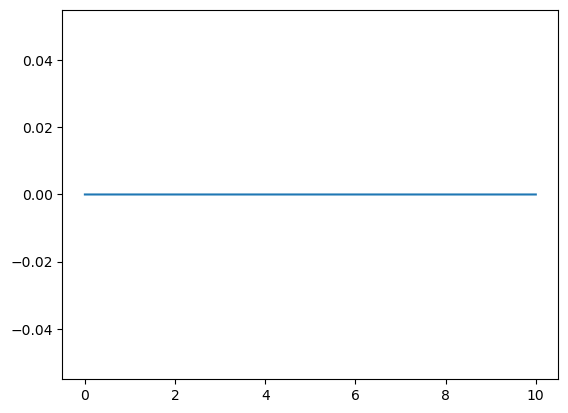

In [3]:
fig, ax = plt.subplots()
ax.plot(np.squeeze(tout), np.squeeze(y_pre1.numpy()))
plt.show()

Here we can finally create a SNSCell and make use of the predefined sparse wiring structures of the torchSNS package. We will define a fully-connected RNN.

... and train our network 

In [10]:
tout = loadmat('tt.mat')
tout = np.transpose(tout["tt"])

y_pre = loadmat('y_pre.mat')
y_pre = np.transpose(y_pre["y_pre"])

y_post = loadmat('y_post.mat')
y_post = np.transpose(y_post["y_post"])

In [12]:
y_post.shape

(1, 50065)

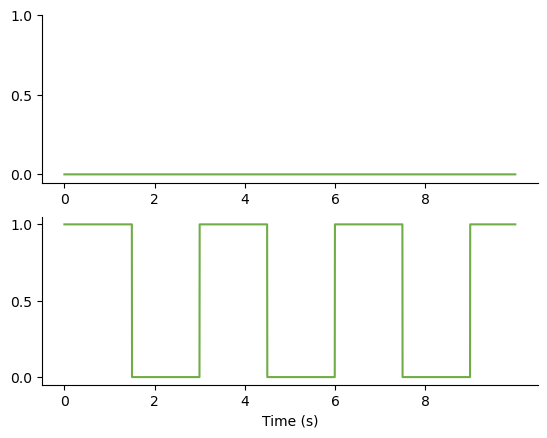

In [19]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

fig, ax = plt.subplots()
plt.subplot(211)
plt.plot(np.squeeze(tout), np.squeeze(y_pre1.numpy()), color=(112/255, 173/255, 71/255))
plt.xticks(np.arange(0, 10, step=2))
plt.yticks([0,0.5,1])

plt.subplot(212)
plt.plot(np.squeeze(tout), np.squeeze(y_pre2.numpy()), color=(112/255, 173/255, 71/255))
plt.xticks(np.arange(0, 10, step=2))
plt.yticks([0,0.5,1])
plt.xlabel("Time (s)")

plt.show()

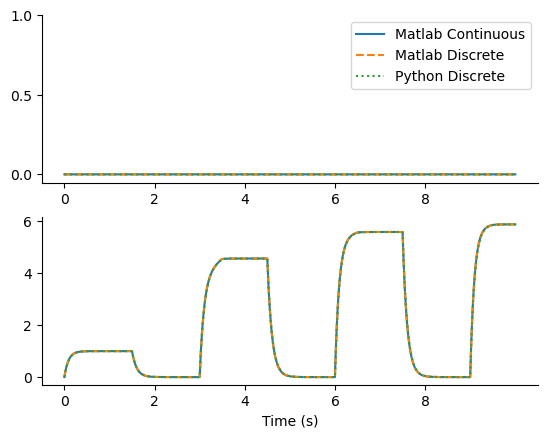

In [71]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

fig, ax = plt.subplots(2)
ax[0].plot(np.squeeze(tout), np.squeeze(y_post1_continous_mat.numpy()), label = "Matlab Continuous")
ax[0].plot(np.squeeze(tout), np.squeeze(y_post1_discrete_mat.numpy()), linestyle ="dashed", label = "Matlab Discrete")
ax[0].plot(np.squeeze(tout), np.squeeze(y_post_python_modulation.numpy()[0,:,0]), linestyle ="dotted", label = "Python Discrete")
ax[0].set_xticks(np.arange(0, 10, step=2))
ax[0].set_yticks([0,0.5,1])
ax[0].legend()

ax[1].plot(np.squeeze(tout), np.squeeze(y_post2_continous_mat.numpy()))
ax[1].plot(np.squeeze(tout), np.squeeze(y_post2_discrete_mat.numpy()), linestyle ="dashed")
ax[1].plot(np.squeeze(tout), np.squeeze(y_post_python_modulation.numpy()[0,:,1]), linestyle ="dotted", label = "Python Discrete")
ax[1].set_xticks(np.arange(0, 10, step=2))
ax[1].set_xlabel("Time (s)")

plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.squeeze(tout), np.squeeze(states.numpy()))
plt.show()

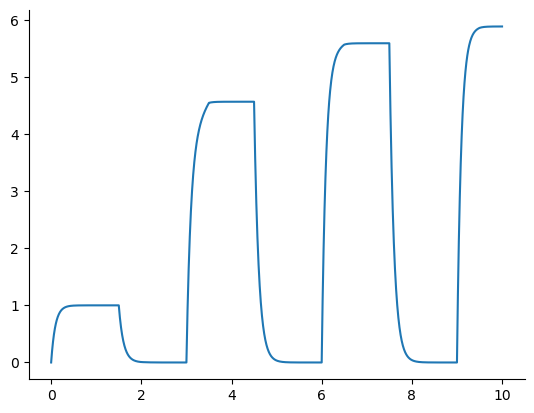

In [66]:
fig, ax = plt.subplots()
ax.plot(np.squeeze(tout), np.squeeze(y_post_python_modulation.numpy()[0,:,1]))
plt.show()

In [16]:
y_pre.shape

(1, 50065)

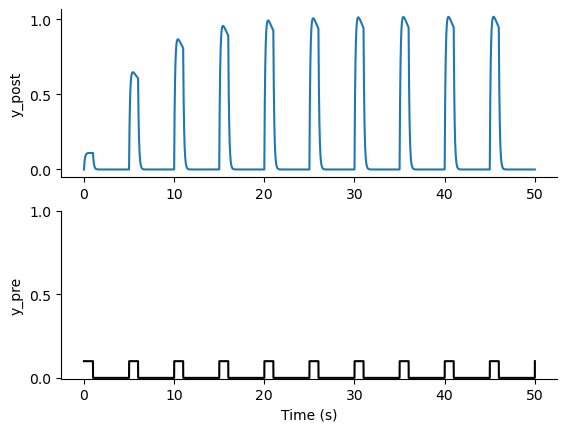

In [46]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

fig, ax = plt.subplots(2)
ax[0].plot(tout[0,:], y_post[0,:])
ax[0].set_yticks([0,0.5, 1])
ax[0].set_ylabel("y_post")

ax[1].plot(tout[0,:], y_pre[0,:], color='black')
ax[1].set_yticks([0,0.5, 1])
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("y_pre")

plt.show()

In [24]:
y_post[0,:].shape

(50065,)

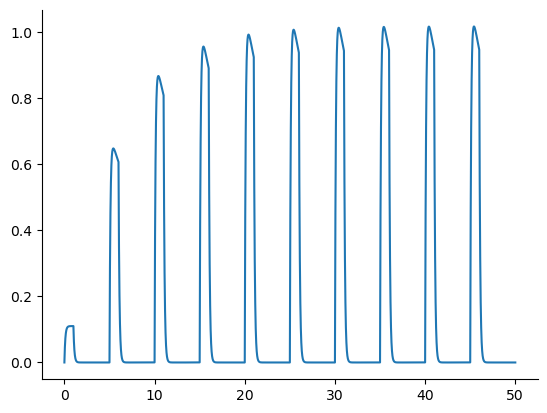

In [25]:
fig, ax = plt.subplots()
ax.plot(tout[0,:], y_post[0,:])

In [ ]:
batch_size = y_pre.size(0)
seq_len = y_pre.size(1)
state_size = modulation_layer_1.state_size
hidden_state = torch.zeros((batch_size, state_size))
buffer_size = modulation_layer_1.buffer_size
a = torch.zeros((batch_size, state_size))
buffer = torch.zeros((batch_size, buffer_size, state_size))
output = []
ass = []
states = []
for t in range(seq_len):
    inputs = y_pre[:, t]
    new_output, hidden_state, a, buffer = modulation_layer_1.forward(inputs, hidden_state, a, buffer)
    output.append(new_output)
    ass.append(a)
    states.append(hidden_state)
outputs = torch.stack(output, dim=1)  # return entire sequence
c = torch.stack(ass, dim=1)  # return entire sequence
states = torch.stack(states, dim=1)  # return entire sequence

In [ ]:
output

In [ ]:
tout = loadmat('tout.mat')
tout = np.transpose(tout["tout"])
y_pre = loadmat('y_pre.mat')
y_pre = np.transpose(y_pre["y_pre"])
y_pre = torch.Tensor(np.expand_dims(y_pre, axis=-1))
y_post = loadmat('y_post.mat')
y_post = np.transpose(y_post["y_post"])
y_post = torch.Tensor(np.expand_dims(y_post, axis=-1))
a_mat = loadmat('a.mat')
a_mat = np.transpose(a_mat["a"])
a_mat = torch.Tensor(np.expand_dims(a_mat, axis=-1))

In [ ]:
y_post.shape

In [ ]:
print(np.shape(X_1))

In [ ]:
SNS_sequence_modulation.rnn_cell._params["tau"]

In [ ]:
wiring = tSNS.wirings.FullyConnected(1, out_features, self_connections=False)  # 1 units, 1 motor neurons
SNS_cell = SNSCell(wiring, in_features)
SNS_sequence = RNNSequence(SNS_cell)

with torch.no_grad():
    SNS_sequence.rnn_cell._params["b"].requires_grad = False
    SNS_sequence.rnn_cell._params["b"].data = torch.Tensor(np.zeros(1))
    SNS_sequence.rnn_cell._params["input_w"].requires_grad = False
    SNS_sequence.rnn_cell._params["input_w"].data = torch.Tensor(np.ones(in_features))
    SNS_sequence.rnn_cell._params["input_b"].requires_grad = False
    SNS_sequence.rnn_cell._params["input_b"].data = torch.Tensor(np.zeros(in_features))
    SNS_sequence.rnn_cell._params["output_w"].requires_grad = False
    SNS_sequence.rnn_cell._params["output_w"].data = torch.Tensor(np.ones(out_features))
    SNS_sequence.rnn_cell._params["output_b"].requires_grad = False
    SNS_sequence.rnn_cell._params["output_b"].data = torch.Tensor(np.zeros(out_features))
    SNS_sequence.rnn_cell._params["sensory_mu"].requires_grad = False
    SNS_sequence.rnn_cell._params["sensory_mu"].data = torch.Tensor(10*np.ones((in_features,1)))
    SNS_sequence.rnn_cell._params["sensory_sigma"].requires_grad = False
    SNS_sequence.rnn_cell._params["sensory_sigma"].data = torch.Tensor(10*np.ones((in_features,1)))

optimizer = torch.optim.Adam(SNS_sequence.parameters(), lr=0.1)
def data_gen():
    for epoch in range(10):
        for data_x,data_y in dataloader:
            def closure():
                y_hat = SNS_sequence.forward(data_x)
                y_hat = y_hat.view_as(data_y)
                loss = nn.MSELoss()(y_hat, data_y)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(SNS_sequence.parameters(),1)
                return loss

            optimizer.step(closure)
            SNS_sequence.rnn_cell.apply_weight_constraints()

            with torch.no_grad():
                x_1 = np.arange(0, 20, 0.1)
                x_2 = np.arange(0, 20, 0.1)
                X_1, X_2 = np.meshgrid(x_1, x_2)
                inputs = np.stack([X_1,X_2],axis=-1)
                inputs = torch.Tensor(inputs).reshape(-1,2)
                sensory_matrix = SNS_sequence.rnn_cell._sigmoid(
                    inputs, SNS_sequence.rnn_cell._params["sensory_mu"], SNS_sequence.rnn_cell._params["sensory_sigma"]
                )
                sensory_activation = sensory_matrix*SNS_sequence.rnn_cell._params["sensory_sparsity_mask"]
                sensory_rev_activation = SNS_sequence.rnn_cell._params["sensory_erev"] * sensory_activation
                sensory_rev = torch.sum(sensory_rev_activation, dim=1)

                state = torch.zeros(
                    (200*200, SNS_sequence.rnn_cell.state_size)
                )

                for neuron_index in range(SNS_sequence.rnn_cell.state_size):
                    state_matrix = SNS_sequence.rnn_cell._sigmoid(
                        state, SNS_sequence.rnn_cell._params["mu"][:,neuron_index], SNS_sequence.rnn_cell._params["sigma"][:,neuron_index]
                    )

                    state_activation = state_matrix*SNS_sequence.rnn_cell._params["sparsity_mask"][:,neuron_index]
                    state_rev_activation = SNS_sequence.rnn_cell._params["erev"][:,neuron_index] * state_activation

                    # Reduce over dimension 1 (=source neurons)
                    state[:,neuron_index] = torch.sum(state_rev_activation, dim=1) + sensory_rev[:,neuron_index] + SNS_sequence.rnn_cell._params["b"][neuron_index]

                outputs = SNS_sequence.rnn_cell._map_outputs(state)[:,-1]
                Y = outputs.reshape(200,200).numpy()
                yield [X_1, X_2], Y

def run(data):
    # update the data
    cnt, [X_1, X_2], Y = data
    for tp in CS[0].collections:
        tp.remove()
    CS[0] = ax.contour(X_1, X_2, Y + cnt/100, levels=levels, extend='both')
    l.set_data(np.arange(0,1,0.01),np.arange(0,1,0.01) + cnt/100)

    return CS[0].collections, l

fig, ax = plt.subplots()
delta = 0.001
x_1 = np.arange(0, 1, delta)
x_2 = np.arange(0, 1, delta)
X_1, X_2 = np.meshgrid(x_1, x_2)
Y = X_1 + X_2
levels = np.arange(0,1.1,0.25)
CS = [ax.contour(X_1, X_2, Y, levels=levels, extend='both')]
CB = fig.colorbar(CS[0], ax=ax, shrink=0.8, extend='both')
l, = ax.plot([],[],lw=2)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
#CB = fig.colorbar(CS, shrink=0.8)

ani = animation.FuncAnimation(fig, run, data_gen, interval=10)
plt.show()

In [ ]:
for tp in CS.collections:
    tp.remove()

In [ ]:
CS[0].collections

In [ ]:
def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,